## Загружаем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import statistics
import re

# визуализация
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns 
%matplotlib inline

# кодировка
import category_encoders as ce

# нормализация и стандартизация
from sklearn import preprocessing

# разделение данный для обучения:
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import LabelEncoder

# констурирование модели и формирование метрики
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# анализ настроения
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')



#загрузка файлов с kaggle
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/frodo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

In [3]:
# фиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

# 0 Данные из соревнования

Соединяем оба дата сета в один для удобства обработки.

In [4]:
# Подгрузка данных для Kaggle
# DATA_DIR = '/kaggle/input/sf-booking/'
# df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
# df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
# sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [5]:
df_train = pd.read_csv('data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('data/submission.csv') # самбмишн

In [6]:
df_test['test'] = 1
df_test['reviewer_score'] = 0
df_train['test'] = 0 
# итоговый дата сет с возможностью выделению тестовых данных
data = df_test.append(df_train, sort=False).reset_index(drop=True) 

<ipython-input-6-a9e7d1a349a7>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True)


In [7]:
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,test,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,1,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,1,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,1,0.0


Посмотрим начальную корреляцию признаков

<AxesSubplot:>

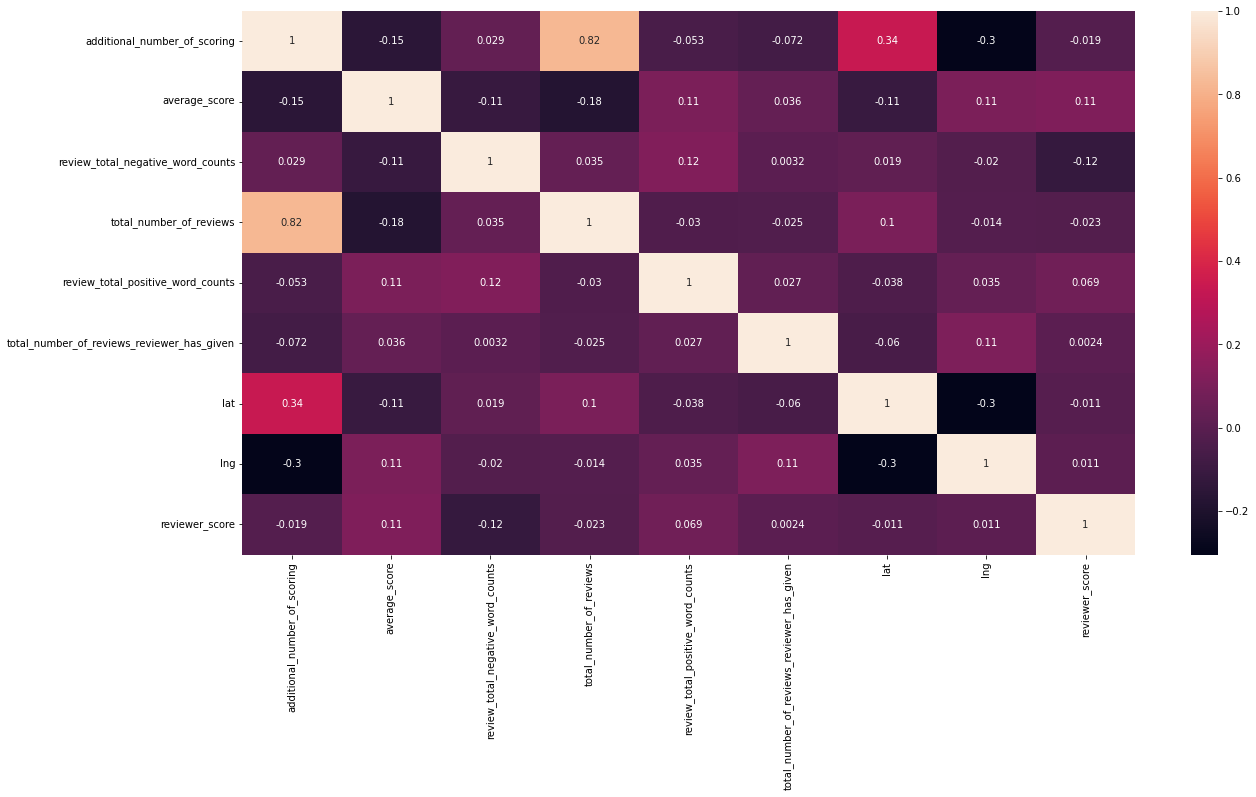

In [8]:
plt.figure(figsize=(20,10))
sns.heatmap(data.drop(['test'], axis=1).corr(), annot=True)

## 1 Очистка данных

Проверим пропуски

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Пропуски в признаках 'lat' и 'ing' можно заполнить на основнаии города в котором находится отель

In [10]:
# получаем название города
data['city'] = data['hotel_address'].apply(lambda x: x.split(' ')[-2])
data['city'] = data['city'].apply(lambda x: 'London' if x == 'United' else x)
display(data['city'].value_counts())

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64

Координаты европейский городов по данным Wikipedia:
Париж       48°50′ с. ш. 2°20′ в. д.
Вена        48°13′00″ с. ш. 16°22′24″ в. д.
Барселона   41°23′ с. ш. 2°11′ в. д.
Лондон      51°30′26″ с. ш. 00°07′39″ з. д.
Милан       45°28′00″ с. ш. 09°10′00″ в. д.
Амстердам   52°23′ с. ш. 4°54′ в. д.


In [11]:
# заполним пропуски долготы и широты нулями для удобства
values = {
    'lat': 0,
    'lng': 0,
}
data = data.fillna(values)

In [12]:
# заполним координаты в зависисмости от города
def lat_fillna(x):
    lat = x[0]
    city = x[1]
    if city == 'Paris' and lat == 0:
        return 48.5000
    elif city == 'Vienna' and lat == 0:
        return 48.1300
    elif city == 'Barcelona' and lat == 0:
        return 41.2300
    elif city == 'London' and lat == 0:
        return 51.3026
    elif city == 'Milan' and lat == 0:
        return 45.2800
    elif city == 'Amsterdam' and lat == 0:
        return 52.2300
    else:
        return lat

def lng_fillna(x):
    lng = x[0]
    city = x[1]
    if city == 'Paris' and lng == 0:
        return 2.2000
    elif city == 'Vienna' and lng == 0:
        return 16.2224
    elif city == 'Barcelona' and lng == 0:
        return 2.1100
    elif city == 'London' and lng == 0:
        return 0.0739
    elif city == 'Milan' and lng == 0:
        return 9.1000
    elif city == 'Amsterdam' and lng == 0:
        return 4.5400
    else:
        return lng

  
data['lng'] = data[['lng', 'city']].apply(lng_fillna, axis = 1)   
data['lat'] = data[['lat', 'city']].apply(lat_fillna, axis = 1)

In [13]:
# убеждаемся в том, что все пропуски удалены
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Проверим дубликаты

In [14]:
# data_duplicates = data[data.duplicated()]
# print(data_duplicates.shape[0])
# Удалим дублирующиеся строки
# data = data.drop_duplicates()

## 2 Проектирование признаков

#### Проработаем признак адреса

In [15]:
#добавляем признак плотности населения городов (по данным Wiki)

population = {
    'London': 8961989,
    'Paris': 2148327, 
    'Vienna': 1921153,
    'Barcelona': 1664182,
    'Milan': 1399860,
    'Amsterdam': 872757
}

data['town_population'] = data['city'].map(population)

Text(0.5, 1.0, 'Средний рейтинг в зависимости от города')

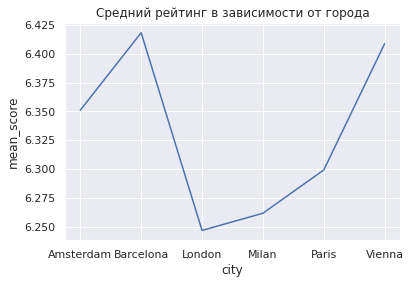

In [16]:
# Проверим есть ли зависимость рейтинга от города
grouped = data.groupby('city', as_index=False).agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))

sns.set_theme()
fig = sns.lineplot(data=grouped, x='city', y='mean_score', markers=True)
fig.set_title('Средний рейтинг в зависимости от города')

В Лондоне Милане и Париже средний рейтинг ниже чем в Барсеоне, Амстердаме и Вене.
Возможная причина: Лондон, Милан, Париж -  крупные города агломерации, в тоже время Амстердам , Вена, и Барселона более нацеленные на туристический бизнес с более высоким уровнем сервиса

In [17]:
# Города у нас выжены через их население а следственно этот прирнак можно удалить

data = data.drop(['city'], axis=1)

In [18]:
# адрес больше не нужен признак можно удалить
data = data.drop(['hotel_address'], axis=1)

#### Сформируем признак сезонности. 
(Полагаем, что отзыв написан сразу после посещения отеля иначе это исказит данные)

In [19]:
data['review_date'] = pd.to_datetime(data['review_date'])  
data['review_month'] = data['review_date'].dt.month.astype(int)

# приводим количество дней с даты отзыва к числу
data['days_since_review'] = data['days_since_review'].apply(lambda x: x.split()[0]).astype('int')

Дополинетельная возможность для исследования: Для путешественника интересны самые свежие данные при выборе отеля, можно брать данные только за последний год т.е. days_since_review <= 365. Имеет сымсл при подборе рекомендации отеля для путешетсвенников.


Text(0.5, 1.0, 'Распределение отзывов по месяцам')

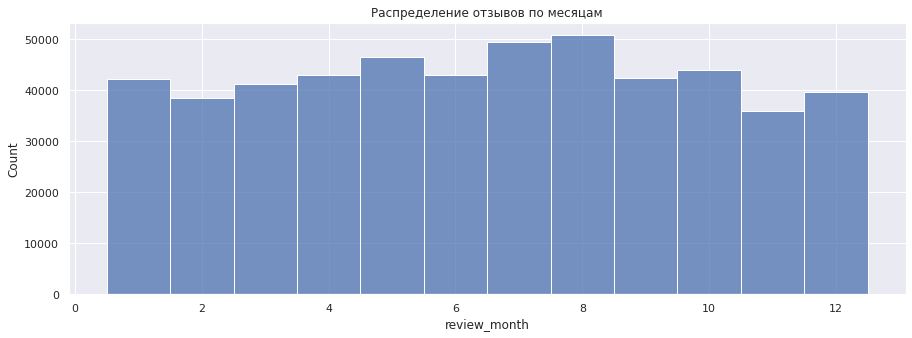

In [20]:
# Оценим распределения отзывов
sns.set_theme()
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 5))

sns.histplot(data=data, x='review_month', discrete=True, ax=ax)
ax.set_title('Распределение отзывов по месяцам')


Наибольшее количество отзывов приходятся на Май, Июль, Август и Октябрь -  высокий сезон
Январь, Март, Апрель, Июнь, Сентябрь - средний сезон
Февраль, Ноябрь, Декабрь - низкий сезон


In [21]:
# Сезонность туризма по Европе
def season (x):
    if x  in (5,7,8,10):
        return 'Hight'
    elif x  in (2,11,12):
        return 'Low'
    else:
        return 'Medium'

data['season'] = data['review_month'].apply(season)  

encoder = ce.OneHotEncoder(cols=['season'], use_cat_names=True) 
type_bin = encoder.fit_transform(data['season'])
data = pd.concat([data, type_bin], axis=1)

In [22]:
# удаляем отработатнный признак
data = data.drop(['review_date'], axis=1)

 #### Обработаем топовые теги которые оставляют рецензенты

In [23]:
# Функция извелечения и всех тэгов
def tags_func(tag_find):
    tag_result = re.findall("'[^\'](.+?)[^\']'",tag_find)
    return tag_result
alltags=data['tags'].apply(tags_func).explode().value_counts().to_frame() # формируем датафрейм

In [24]:
top = list(alltags.index[:20])
display(top)

['Leisure trip',
 'Submitted from a mobile device',
 'Couple',
 'Stayed 1 night',
 'Stayed 2 nights',
 'Solo traveler',
 'Stayed 3 nights',
 'Business trip',
 'Group',
 'Family with young children',
 'Stayed 4 nights',
 'Double Room',
 'Standard Double Room',
 'Superior Double Room',
 'Family with older children',
 'Deluxe Double Room',
 'Double or Twin Room',
 'Stayed 5 nights',
 'Standard Double or Twin Room',
 'Classic Double Room']

In [25]:
data['tags'] = data['tags'].apply(lambda x: x[3:-3].split(" ', ' "))

# проводим кодировку принадлежности отзыва к топу тэгов
for tag in top:
    data[tag] = data['tags'].apply(lambda x: 1 if tag in x else 0)

In [26]:
#удаляем отработатнный признак
data = data.drop(['tags'], axis=1)
data.head(3)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,Stayed 4 nights,Double Room,Standard Double Room,Superior Double Room,Family with older children,Deluxe Double Room,Double or Twin Room,Stayed 5 nights,Standard Double or Twin Room,Classic Double Room
0,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,...,0,1,0,0,0,0,0,0,0,0
1,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,...,0,0,0,0,0,0,0,0,0,0
2,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,...,0,0,0,0,0,0,0,0,0,0


#### Получим информацию по стране рецензента

In [27]:
# составим топ 
top_rev_nation = data['reviewer_nationality'].value_counts().nlargest(10).index
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in top_rev_nation else 'Other')

# закодируем
encoder = ce.OneHotEncoder(cols=['reviewer_nationality'], use_cat_names=True) 
type_bin = encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

####  Рассматриваем признаки с отзывами

In [28]:
# закодируем фактическое наличие негативного и позитивного отзывов
data['negative'] = data['negative_review'].apply(lambda x: 0 if x == 'No Negative' else 1)
data['positive'] = data['positive_review'].apply(lambda x: 0 if x == 'No Positive' else 1)

In [29]:
# анализируем отзывы пользователей
sent_analyzer = SentimentIntensityAnalyzer()
data['negative_score'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
data['positive_score'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

In [30]:
# под каждую оценку создадим отдельный признак
data.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(data['positive_score'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
data.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(data['negative_score'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)

# удаляем признаки после извлечения из них полезной информации
data.drop(['positive_review', 'negative_review', 'positive_score', 'negative_score'], axis=1, inplace=True)

In [31]:
# убираем обработанные оставшиеся текстовые признаки
object_cols = [x for x in data.columns if data[x].dtypes == 'object']
data.drop(object_cols, axis = 1, inplace=True)

#### Оцениваем значимость признаков

In [32]:
# извлекаем все названия признаков
col_name = data.columns

In [33]:
# числовые признаки
num_cols = ['additional_number_of_scoring',
            'review_total_negative_word_counts',
            'total_number_of_reviews',
            'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given',
            'days_since_review',
            'town_population',
            'p_neg',
            'p_neu',
            'p_pos',
            'p_compound',
            'n_neg',
            'n_neu',
            'n_pos',
            'n_compound']

In [34]:
# вносим оставшиеся колонки в список категориальных
cat_cols=[]
for col in list(col_name):
    if col in num_cols:
        continue
    else:
        cat_cols.append(col)


In [35]:
cat_cols.remove('test')
cat_cols.remove('reviewer_score')

In [36]:
from sklearn.feature_selection import chi2

# оценку значимости категориальных переменных производим с помощью хи-квадрат с выводом графика

y = data.query('test == 0').drop('test',axis=1).reviewer_score.values.astype('int')
X = data.query('test == 0').drop('test',axis=1)[cat_cols]

X['lng_'] = X['lng'] - X['lng'].min() #избавляемся от отрицательных значений
X = X.drop(['lng'], axis=1)



Text(0.5, 1.0, 'Значимость категориальных признаков')

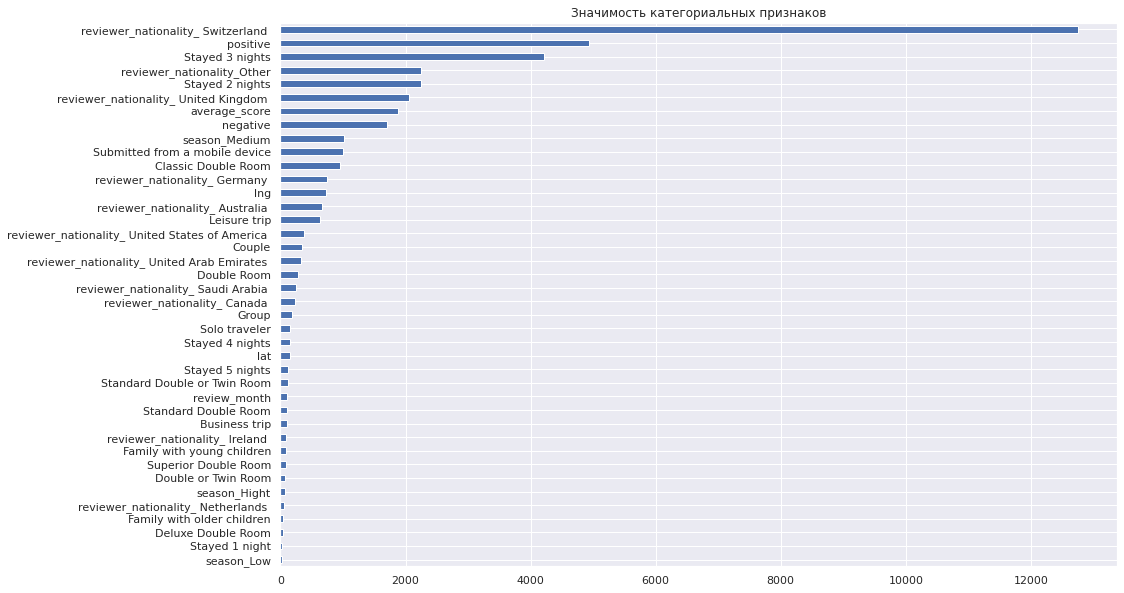

In [37]:
plt.figure(figsize=(15,10))
imp_cat = pd.Series(chi2(X, y)[0],index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
plt.title('Значимость категориальных признаков')

<AxesSubplot:>

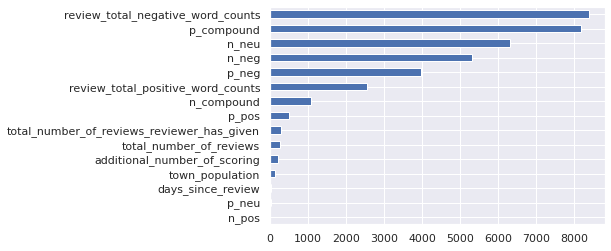

In [38]:
from sklearn.feature_selection import f_classif
# Для оценки значимости непрерывных переменных используем ANOVA

y = data.query('test == 0').drop(['test'], axis=1).reviewer_score.values.astype('int')
X = data.query('test == 0').drop(['test'], axis=1)[num_cols]

imp_num = pd.Series(f_classif(X, y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

#### Нормализация и стандартизация

In [39]:
# Проведем нормализацию данных RobustScaler

r_scaler = preprocessing.RobustScaler()
data_r = r_scaler.fit_transform(data)

data_r = pd.DataFrame(data, columns=col_name)
data_r.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,test,...,negative,positive,p_neg,p_neu,p_pos,p_compound,n_neg,n_neu,n_pos,n_compound
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,...,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,354.441932,49.431627,2.892653,0.250001,...,0.752025,0.930302,0.034865,0.576059,0.388488,0.593533,0.322670,0.619019,0.052941,-0.209151
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,208.928124,3.460612,4.665462,0.433014,...,0.431838,0.254638,0.103444,0.273989,0.235558,0.342460,0.410258,0.392864,0.115535,0.453386
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,41.230000,-0.369758,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.983200,0.000000,0.000000,0.000000,-0.998100
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,175.000000,48.213305,-0.143372,0.000000,...,1.000000,1.000000,0.000000,0.408000,0.230000,0.350600,0.000000,0.000000,0.000000,-0.709600
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,353.000000,51.499981,0.019886,0.000000,...,1.000000,1.000000,0.000000,0.587000,0.404000,0.708900,0.107000,0.781000,0.000000,-0.177900
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,527.000000,51.516288,4.841163,0.750000,...,1.000000,1.000000,0.000000,0.752000,0.588000,0.883400,1.000000,1.000000,0.057000,0.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,730.000000,52.400181,16.429233,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.999300,1.000000,1.000000,1.000000,0.996400


## 3 Отбор признаков

Проведем проверку на мультиколлениарность

In [40]:
pivot = data_r.corr()
pivot = pivot.drop('test', axis=0)
pivot = pivot.drop('test', axis=1)


In [41]:
for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.7 or x == 1) else x)
    # заменим на NAN значения меньше 0.7 и равные 1 (корреляция признака самого к себе)- эти данные не имеют сильной коррелляции
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')

In [42]:
fig = px.imshow(pivot)
fig.show()

In [43]:
# удалим сильно скоррелированые признаки
for col in pivot:
    if (pivot[col].max() > 0.7 and pivot[col].max() < 0.99) or (pivot[col].min() < -0.7 and pivot[col].max() > -0.99):
        pivot = pivot.drop(col, axis=0)
        pivot = pivot.drop(col, axis=1)
        data = data.drop(col, axis=1)

<AxesSubplot:>

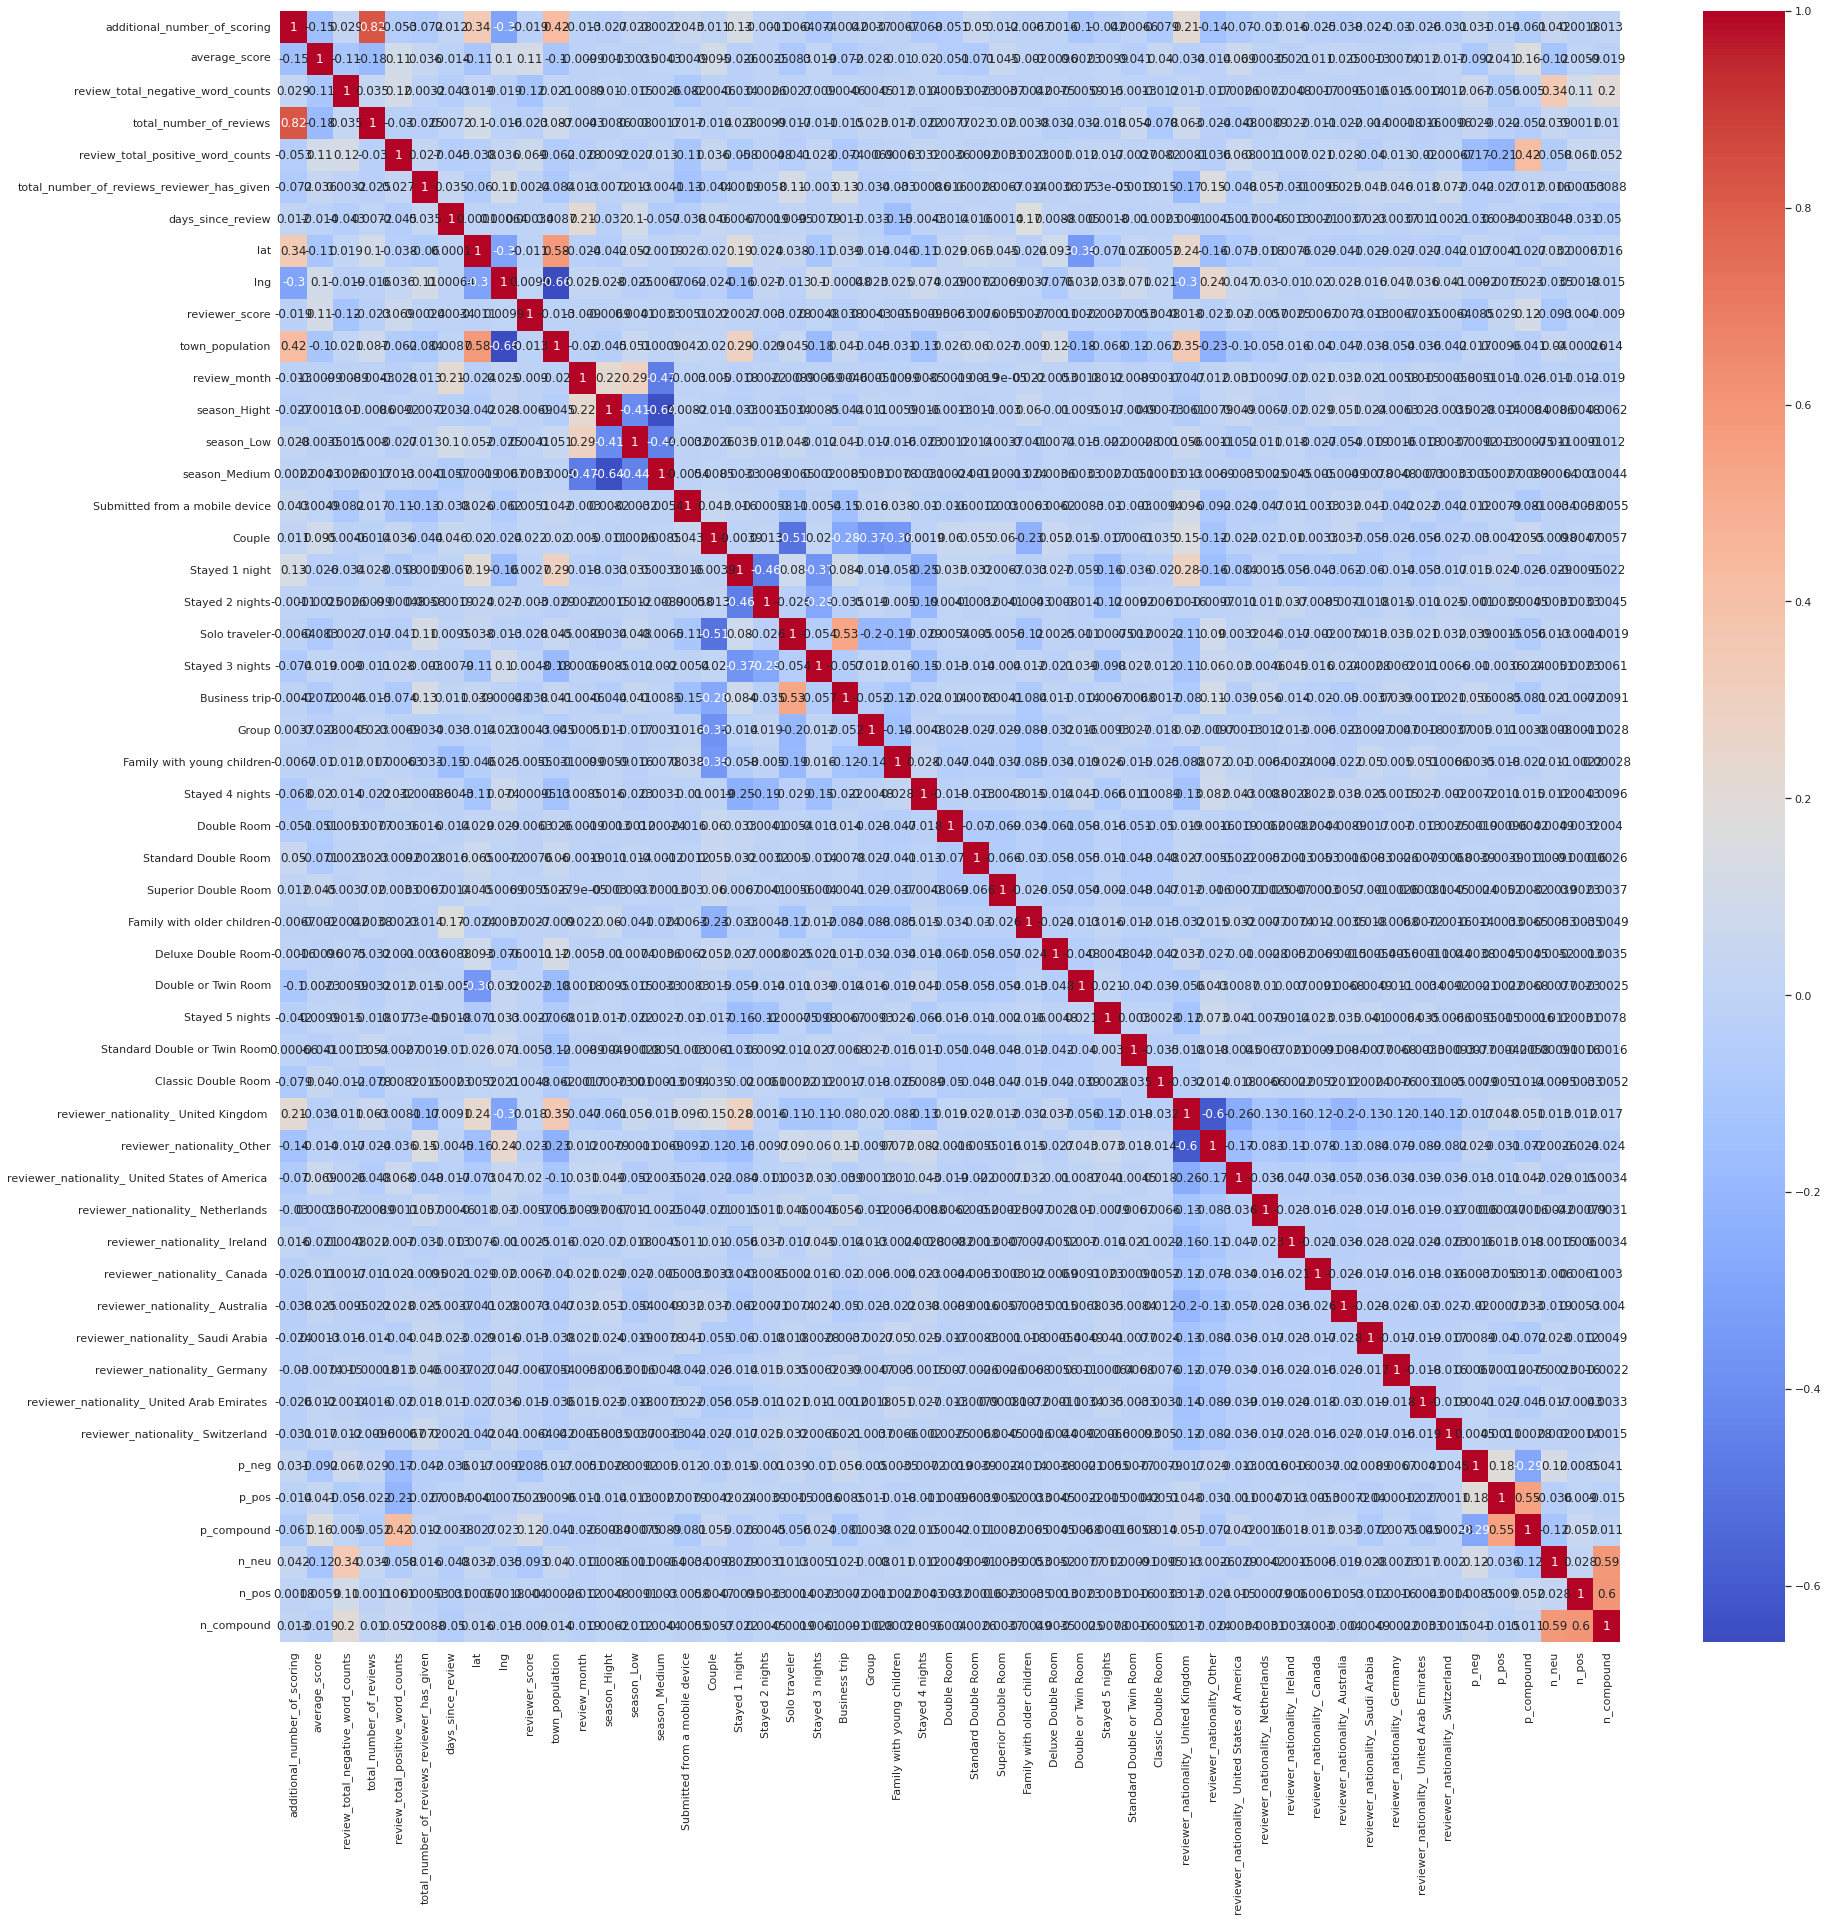

In [44]:
# построим тепловую карту корреляции
plt.rcParams['figure.figsize'] = (30,30)
sns.heatmap(data.drop(['test'], axis=1).corr(), annot=True, cmap='coolwarm')

## 4 Готовим данные для модели

In [45]:
# выделим тестовую часть
train_data = data_r.query('test == 0').drop(['test'], axis=1)
test_data = data_r.query('test == 1').drop(['test'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

In [46]:
# разделяем тренинговый датасет: 80% на обучение, 20% на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [47]:
# проверяем размерности получившихся датасетов
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 56), (386803, 56), (386803, 55), (309442, 55), (77361, 55))

## 5 Создаем и обучаем модель

In [48]:
# создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [49]:
# обучаем модель
model.fit(X_train, y_train)

# используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    6.0s finished


In [50]:
# пишем свою функцию Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [51]:
# сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAE: 0.8753669126993358
MAPE: 12.496702715798438


<AxesSubplot:>

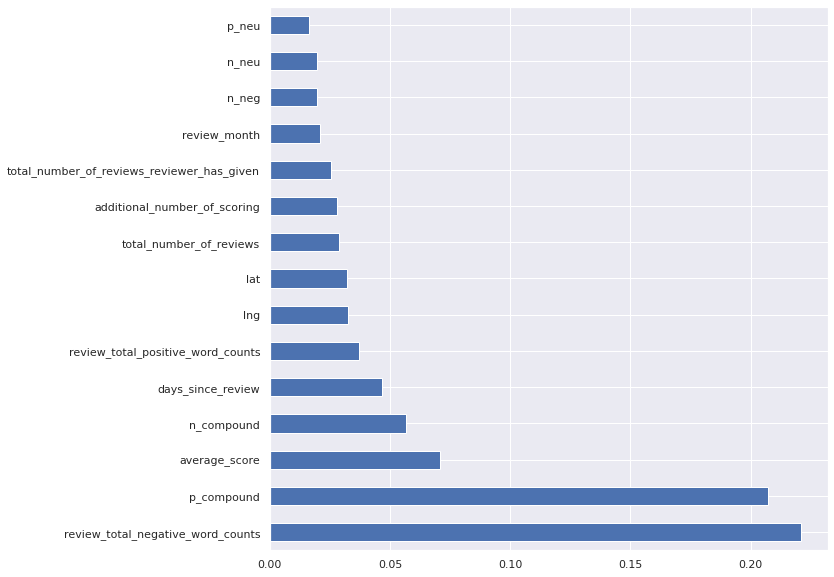

In [52]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [53]:
test_data.sample(3)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,...,negative,positive,p_neg,p_neu,p_pos,p_compound,n_neg,n_neu,n_pos,n_compound
108680,107,9.0,2,917,25,14,14,48.201709,16.371021,0.0,...,1,1,0.0,0.753,0.247,0.7841,0.000,1.000,0.000,0.0000
18961,1005,8.3,31,3469,20,4,37,51.559095,-0.284704,0.0,...,1,1,0.0,0.467,0.533,0.9517,0.000,1.000,0.000,0.0000
5508,328,7.5,79,2197,4,4,479,51.491668,-0.194747,0.0,...,1,1,0.0,0.476,0.524,0.2960,0.181,0.796,0.023,-0.9239


In [54]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [55]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [56]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    8.2s finished


In [57]:
predict_submission

array([8.546, 6.921, 8.705, ..., 8.243, 9.421, 7.032])

In [58]:
list(sample_submission)

['reviewer_score', 'id']

In [59]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission_last.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.546,488440
1,6.921,274649
2,8.705,374688
3,9.800,404352
4,9.567,451596
5,9.195,302161
6,7.753,317079
7,7.589,13963
8,8.208,159785
9,7.384,195089
